In [1]:
!pip install mxnet-cu100mkl

     |████████████████████████████████| 576.6MB 29kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


#AC GAN (Conditional Image Synthesis With Auxiliary Classifier GANs) - MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu()

In [3]:
def transform(data):
    return data.reshape((784)).astype('float32')/255.0

train_mnist = gluon.data.vision.MNIST(train = True).transform_first(transform)

In [4]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(784,)
0


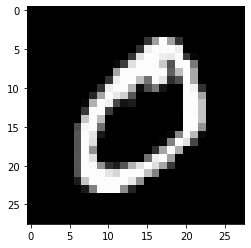

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
plt.show()

##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)

##Building the GAN model

In acgan the discriminator makes two predictions, first one to properly classify the data feeded to it and second one to consider it as true or false.

And likewise the generator in cgan, the generator in acgan also generates data using noise combined with desired output category.

Lets consider __x__ as true data, __y__ as __x__'s labels, __x_hat__ as false data generated by generator when feeded with noise __z__ combined with true labels or classes of true data __x__, __y_true__ as prediction of discriminator for true data for being true, __y_true_classes__ as predicted classes for same, and __y_false__ as prediction of discriminator for false data for being false, __y_false_classes__ as predicted classes for generated data.

So discriminator takes data > predicts its class(using softmax function) and its nature of being true or false(using sigmoid function). Hence it's output layer out will have k + 1 number of neurons where k is number of classes. The softmax is applied to first k neurons and sigmoid to last neuron. This is know as soft-sigmoid activation function.

Discriminator is trained to consider true data as true by minimizing __"-log(y_true)"__ and to consider false data as false data by minimizing __"-log(1 - y_false)"__.... which is basically exactly like vanilla gan

And here is the difference, the discriminator is also trained to correctly predict the classes of __both true data and false data__, by minimizing __"(-y*log(y_true_classes)) + (-y*log(y_false_classes))"__.

And the generator is not only trained to fool the discriminator by minimizing __"-log(y_false)"__ but also to generated data that can be correctly clasified by the classifier by minimizing __"-y*log(y_false_classes)"__.

In [0]:

# ===================== Discriminator Parameters ===========================
dw1 = nd.random.normal(0, 1, (784, 256), ctx = ctx) * 0.001
db1 = nd.random.normal(0, 1, 256, ctx = ctx) * 0.001

# for predicting whether the data is true or false
dw2_source = nd.random.normal(0, 1, (256, 1), ctx = ctx) * 0.001
db2_source = nd.random.normal(0, 1, 1, ctx = ctx) * 0.001

# for predicting class(out of 10) of the data(for both true and false)
dw2_aux = nd.random.normal(0, 1, (256, 10), ctx = ctx) * 0.001
db2_aux = nd.random.normal(0, 1, 10, ctx = ctx) * 0.001
# ==========================================================================

# ======================= Generator Parameters =============================
# after concatenation the input layer would be of shape (-1, 110) that is why we have 110 as input neurons
gw1 = nd.random.normal(0, 1, (110, 256), ctx = ctx) * 0.001

gb1 = nd.random.normal(0, 1, 256, ctx = ctx) * 0.001

gw2 = nd.random.normal(0, 1, (256, 784), ctx = ctx) * 0.001
gb2 = nd.random.normal(0, 1, 784, ctx = ctx) * 0.001
# ==========================================================================

def discriminator(x):
    layer1 = nd.relu(nd.dot(x, dw1) + db1)
    source = nd.sigmoid(nd.dot(layer1, dw2_source) + db2_source) # sigmoid function here(for predicting true or false)
    aux = nd.sigmoid(nd.dot(layer1, dw2_aux) + db2_aux) # and softmax function here(for predicting labels)
    return source, aux

def generator(z, y): # this generator is a conditional generator
    inputs = nd.concat(z, y, dim = 1)
    # z shape: (-1, 100)
    # y shape: (-1, 10)
    # so concat with dimention 1 would be of shape: (-1, 110)
    layer1 = nd.relu(nd.dot(inputs, gw1) + gb1)
    generated = nd.sigmoid(nd.dot(layer1, gw2) + gb2)
    return generated

dparams = [dw1, db1, dw2_source, db2_source, dw2_aux, db2_aux]
gparams = [gw1, gb1, gw2, gb2]

# as we this is an scratch implementation, so we are gonna implement the optimizer from scratch too

dsqrs = [] # for adam optimizer
dvs = [] # for adam optimizer

gsqrs = [] # for adam optimizer
gvs = [] # for adam optimizer

for param in dparams:
    param.attach_grad()
    dsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    dvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    
for param in gparams:
    param.attach_grad()
    gsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    gvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability

## Defining losses

In [0]:
def dloss(true, true_aux, true_labels, false, false_aux, false_labels):
    source_loss = -nd.mean(nd.log(true) + nd.log(1 - false)) # this loss is simply same as vanilla gan loss
    aux_loss = -nd.mean((true_labels * nd.log(true_aux)) + (false_labels * nd.log(false_aux))) # here we are simply doing classification using auxiliary output layer
    return (source_loss + aux_loss)/2.0

def gloss(false, false_aux, false_labels):
    source_loss = -nd.mean(nd.log(false)) # again this loss is exactly same as in vanilla loss
    aux_loss = -nd.mean(false_labels * nd.log(false_aux)) # and here generator will train to generate data whose classes predicted by discriminator is same as true labels
    return (source_loss + aux_loss)/2.0

##Defining optimizer

In [0]:
def adam(t, params, vs, sqrs, lr = 0.001):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        grad = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(grad + 1e-8)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        update = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr + 1e-8) + eps)
        param[:] = param - update
        
def sgd(params, lr = 0.001):
    for param in params:
        param[:] = param - lr * param.grad

##Training the model

Epoch: 0 | Generator Loss: 0.76691 | Discirminator Loss: 0.61689


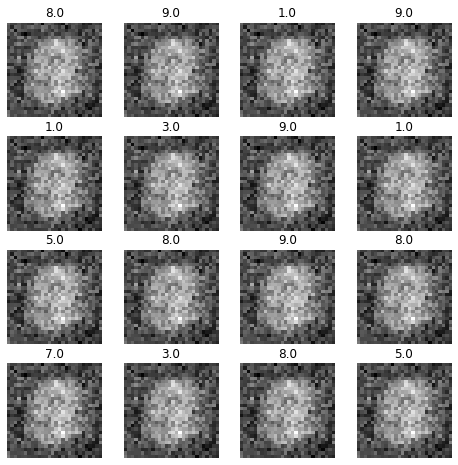

Epoch: 1 | Generator Loss: 2.41610 | Discirminator Loss: 0.09122


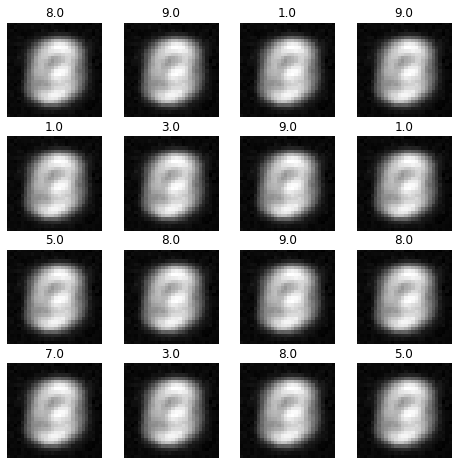

Epoch: 2 | Generator Loss: 3.12867 | Discirminator Loss: 0.02080


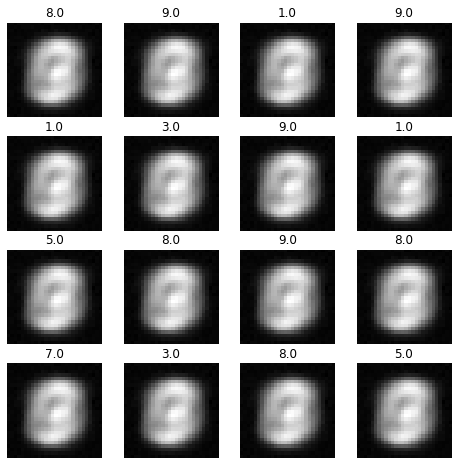

Epoch: 3 | Generator Loss: 1.52814 | Discirminator Loss: 0.15669


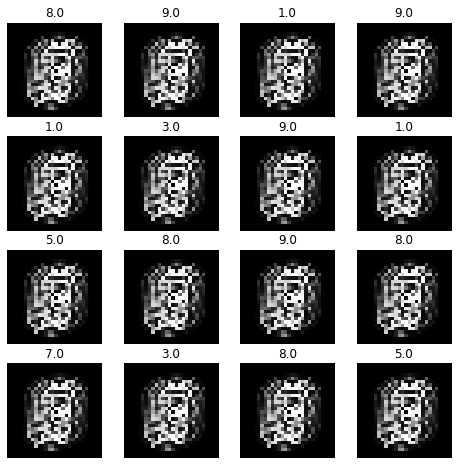

Epoch: 4 | Generator Loss: 1.26068 | Discirminator Loss: 0.16883


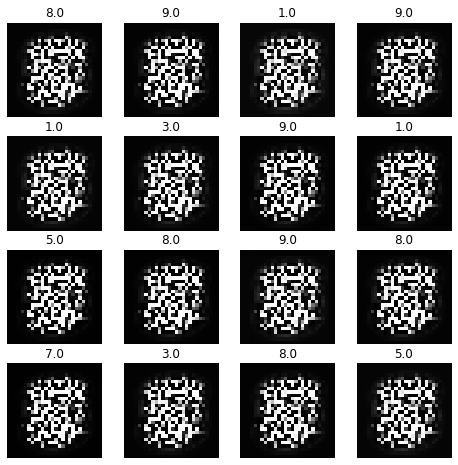

Epoch: 5 | Generator Loss: 2.45866 | Discirminator Loss: 0.02125


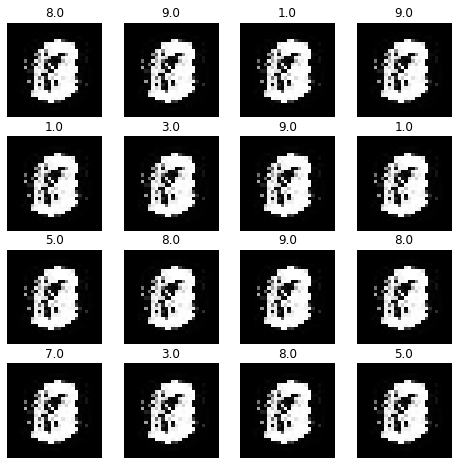

Epoch: 6 | Generator Loss: 2.21241 | Discirminator Loss: 0.02882


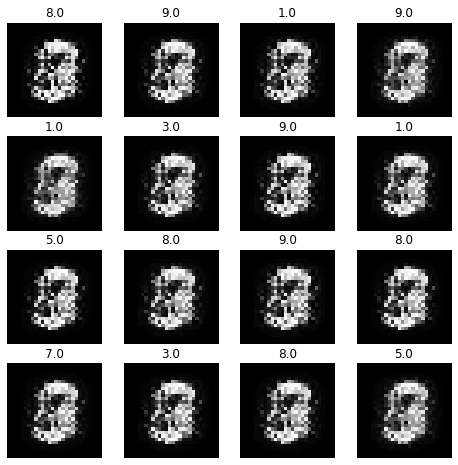

Epoch: 7 | Generator Loss: 1.31577 | Discirminator Loss: 0.11444


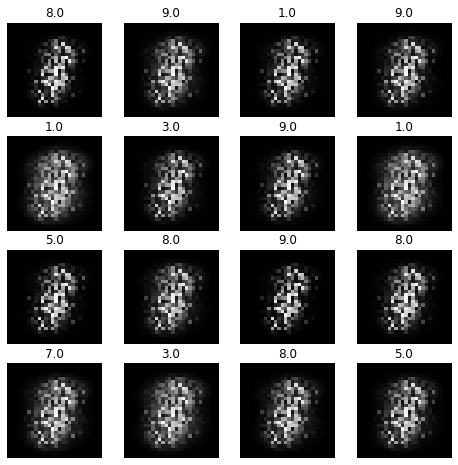

Epoch: 8 | Generator Loss: 1.79722 | Discirminator Loss: 0.05167


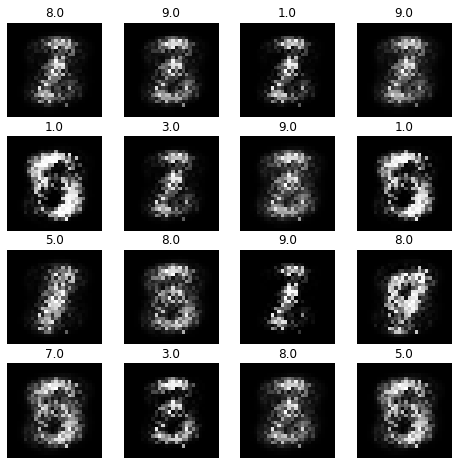

Epoch: 9 | Generator Loss: 1.74481 | Discirminator Loss: 0.06966


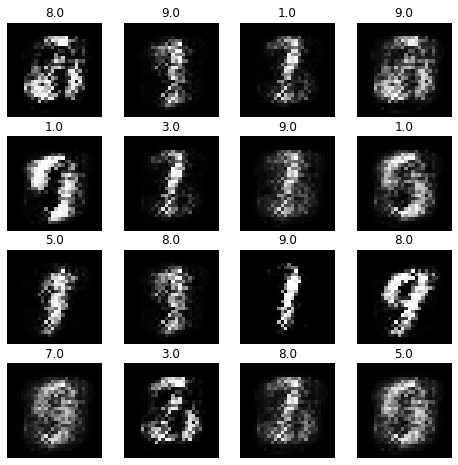

Epoch: 10 | Generator Loss: 1.90779 | Discirminator Loss: 0.05899


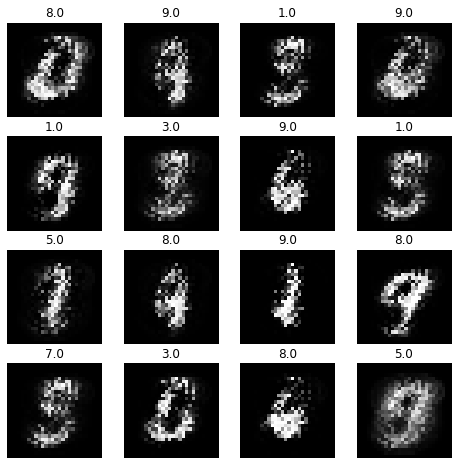

Epoch: 11 | Generator Loss: 1.91529 | Discirminator Loss: 0.07383


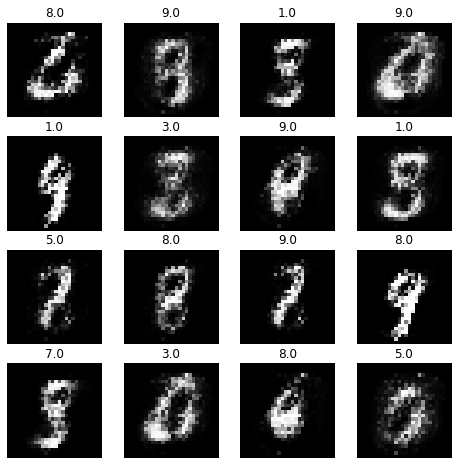

Epoch: 12 | Generator Loss: 1.89013 | Discirminator Loss: 0.09365


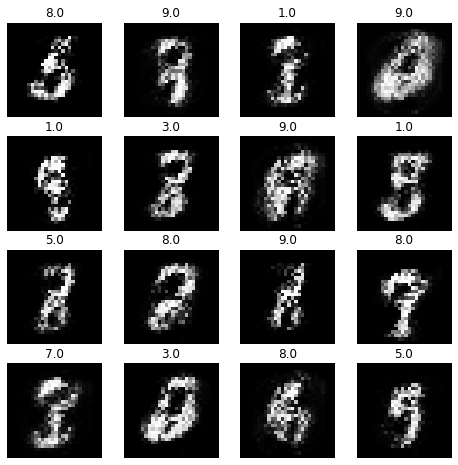

Epoch: 13 | Generator Loss: 1.92652 | Discirminator Loss: 0.10336


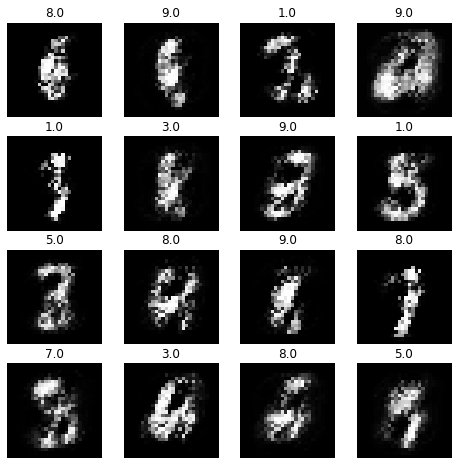

Epoch: 14 | Generator Loss: 1.83689 | Discirminator Loss: 0.13674


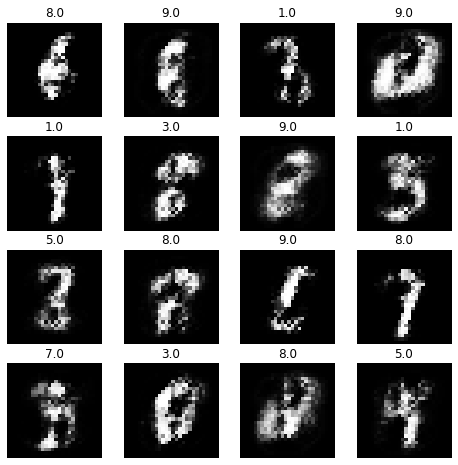

Epoch: 15 | Generator Loss: 1.79094 | Discirminator Loss: 0.16702


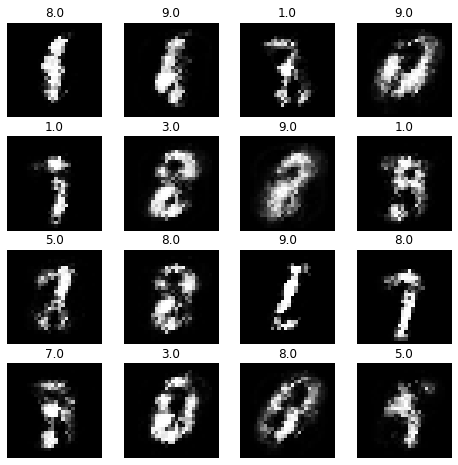

Epoch: 16 | Generator Loss: 1.74679 | Discirminator Loss: 0.19331


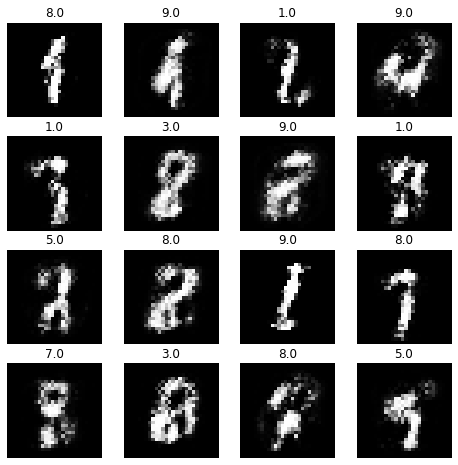

Epoch: 17 | Generator Loss: 1.74436 | Discirminator Loss: 0.20331


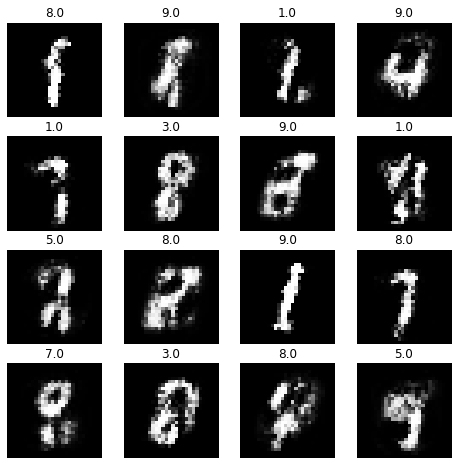

Epoch: 18 | Generator Loss: 1.66398 | Discirminator Loss: 0.21355


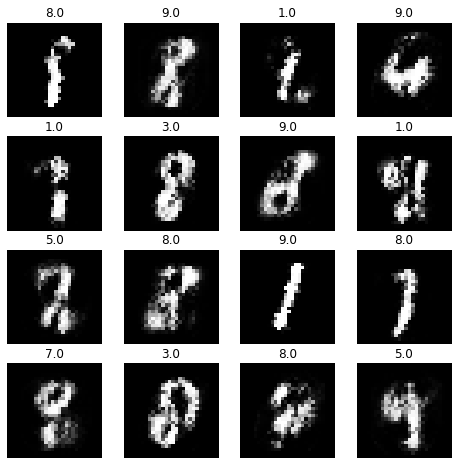

Epoch: 19 | Generator Loss: 1.58108 | Discirminator Loss: 0.23271


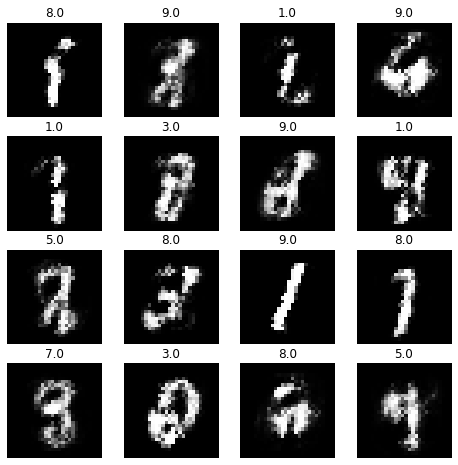

Epoch: 20 | Generator Loss: 1.54832 | Discirminator Loss: 0.24139


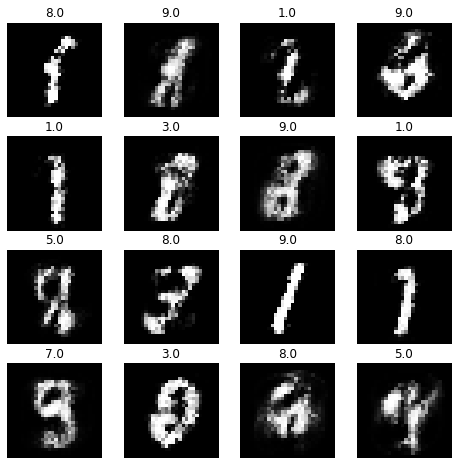

Epoch: 21 | Generator Loss: 1.53207 | Discirminator Loss: 0.24111


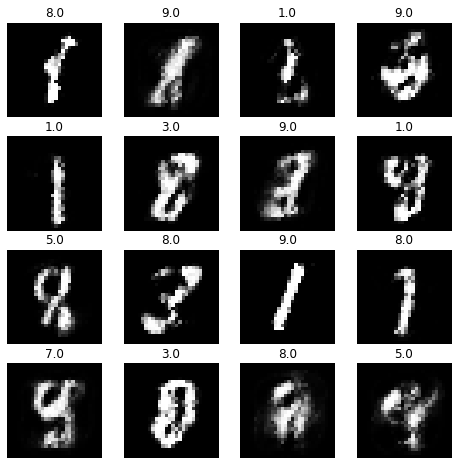

Epoch: 22 | Generator Loss: 1.52219 | Discirminator Loss: 0.25703


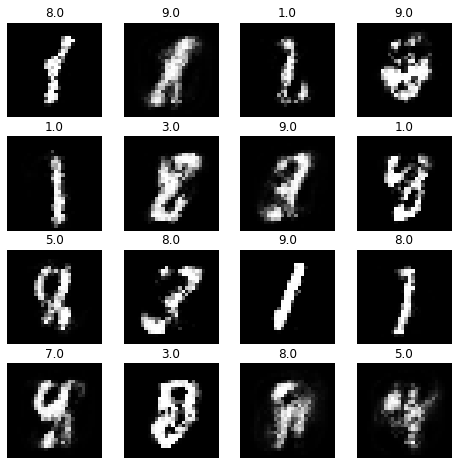

Epoch: 23 | Generator Loss: 1.46988 | Discirminator Loss: 0.26675


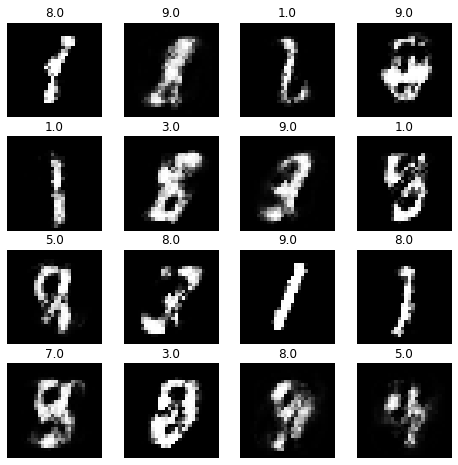

Epoch: 24 | Generator Loss: 1.42388 | Discirminator Loss: 0.26094


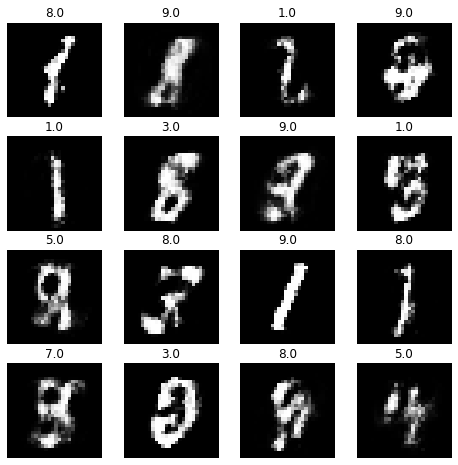

Epoch: 25 | Generator Loss: 1.36830 | Discirminator Loss: 0.27715


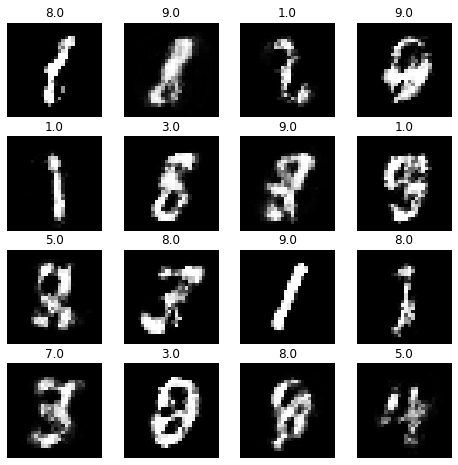

Epoch: 26 | Generator Loss: 1.32981 | Discirminator Loss: 0.30228


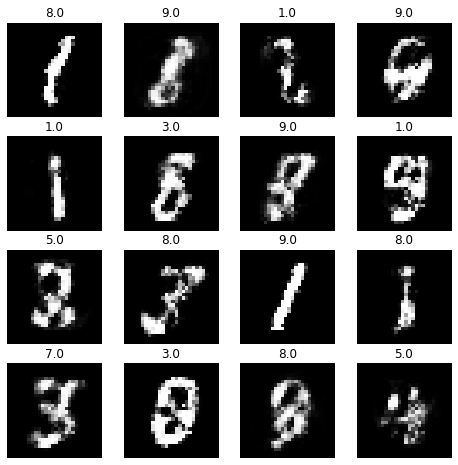

Epoch: 27 | Generator Loss: 1.31397 | Discirminator Loss: 0.29876


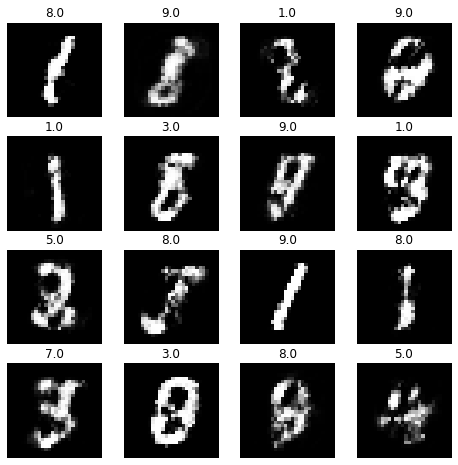

Epoch: 28 | Generator Loss: 1.32036 | Discirminator Loss: 0.30424


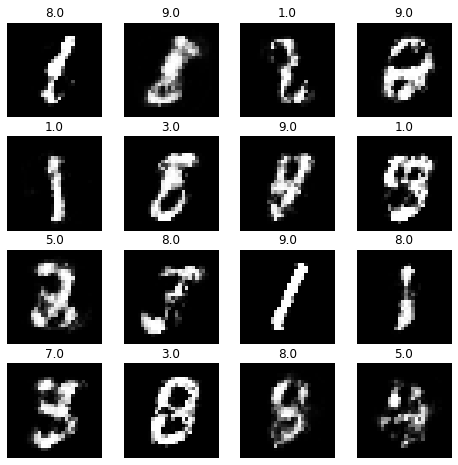

Epoch: 29 | Generator Loss: 1.24326 | Discirminator Loss: 0.30862


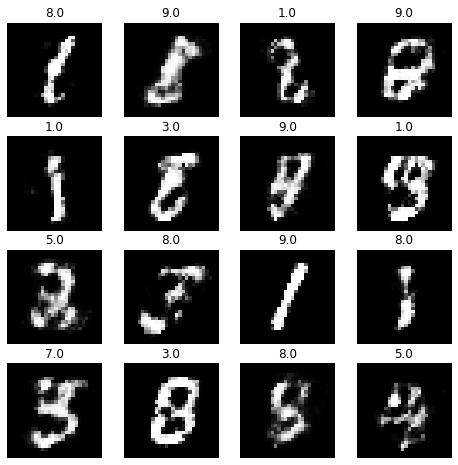

Epoch: 30 | Generator Loss: 1.20669 | Discirminator Loss: 0.30858


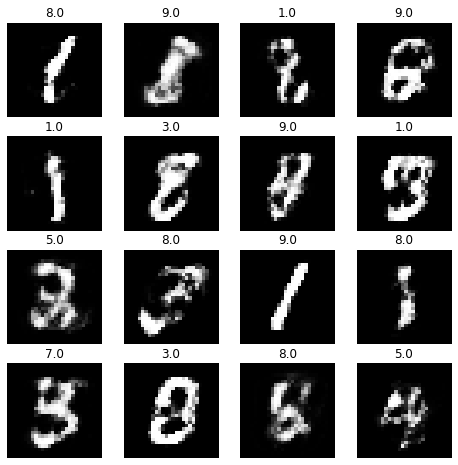

Epoch: 31 | Generator Loss: 1.18681 | Discirminator Loss: 0.31491


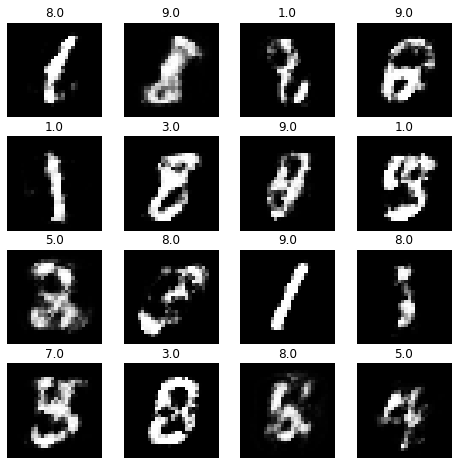

Epoch: 32 | Generator Loss: 1.18113 | Discirminator Loss: 0.31191


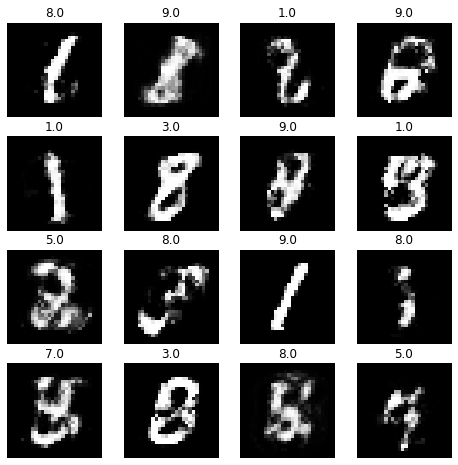

Epoch: 33 | Generator Loss: 1.20008 | Discirminator Loss: 0.30881


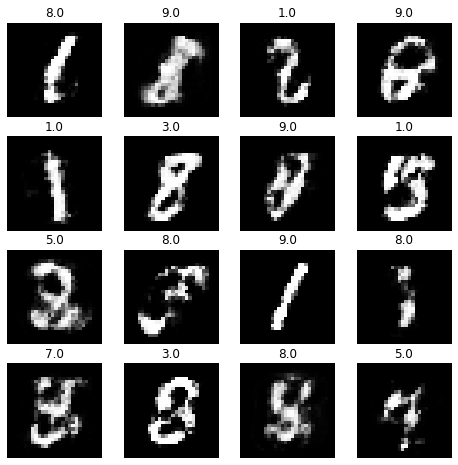

Epoch: 34 | Generator Loss: 1.19189 | Discirminator Loss: 0.31158


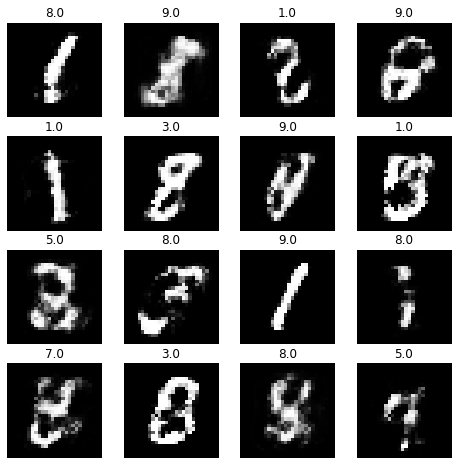

Epoch: 35 | Generator Loss: 1.20552 | Discirminator Loss: 0.30658


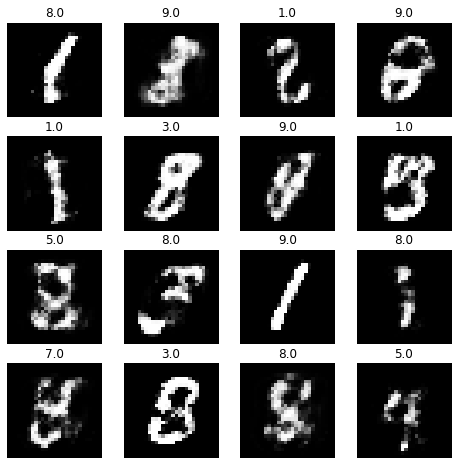

Epoch: 36 | Generator Loss: 1.19918 | Discirminator Loss: 0.30866


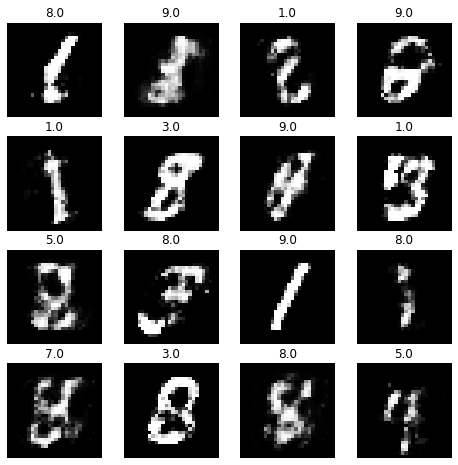

Epoch: 37 | Generator Loss: 1.20148 | Discirminator Loss: 0.30743


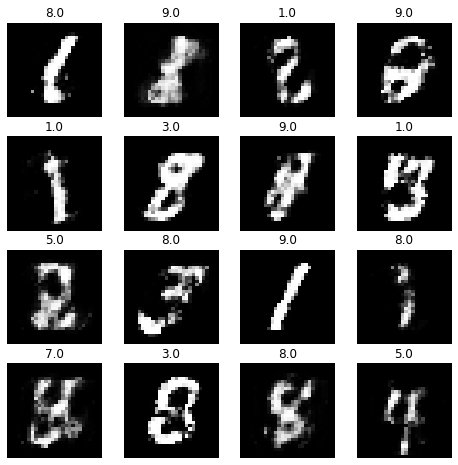

Epoch: 38 | Generator Loss: 1.20933 | Discirminator Loss: 0.30623


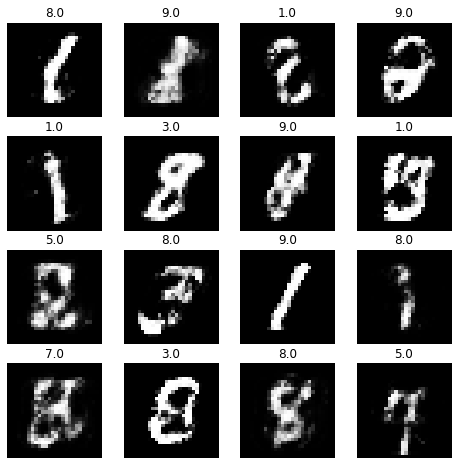

Epoch: 39 | Generator Loss: 1.22803 | Discirminator Loss: 0.29996


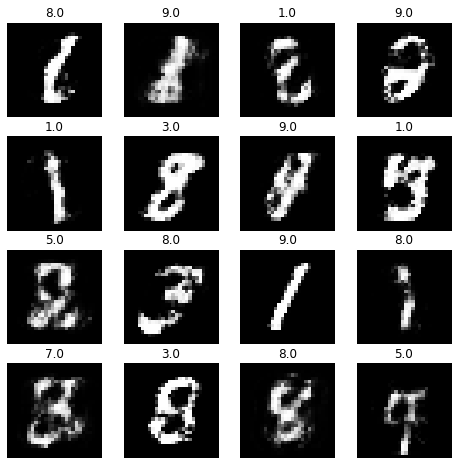

Epoch: 40 | Generator Loss: 1.21481 | Discirminator Loss: 0.30027


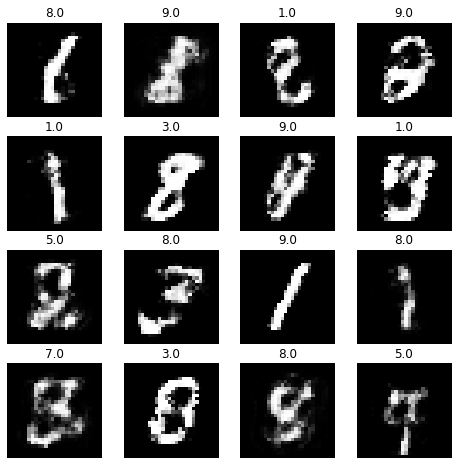

Epoch: 41 | Generator Loss: 1.22906 | Discirminator Loss: 0.29863


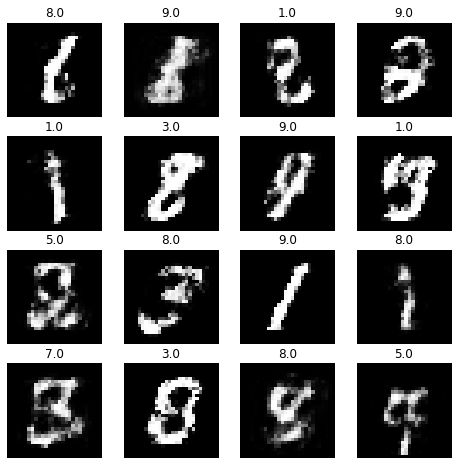

Epoch: 42 | Generator Loss: 1.24863 | Discirminator Loss: 0.29476


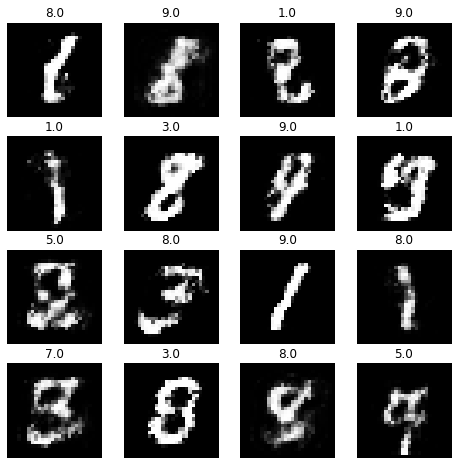

Epoch: 43 | Generator Loss: 1.25910 | Discirminator Loss: 0.29371


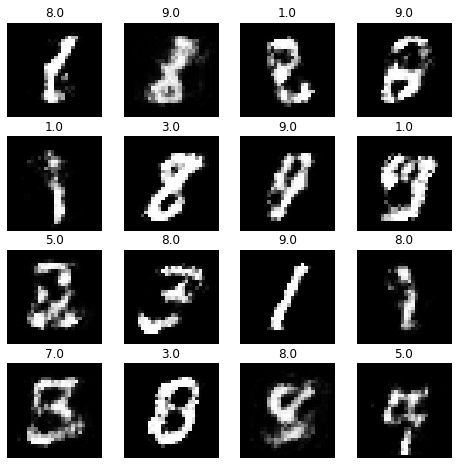

Epoch: 44 | Generator Loss: 1.24746 | Discirminator Loss: 0.29126


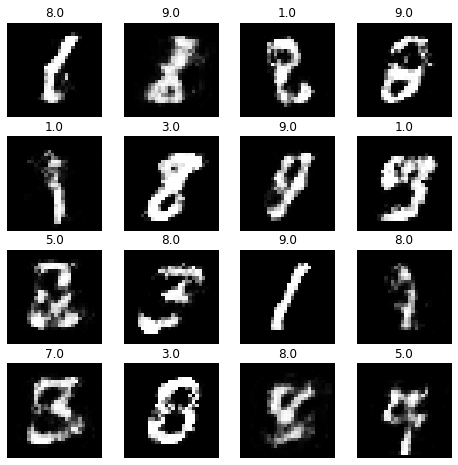

Epoch: 45 | Generator Loss: 1.25388 | Discirminator Loss: 0.28853


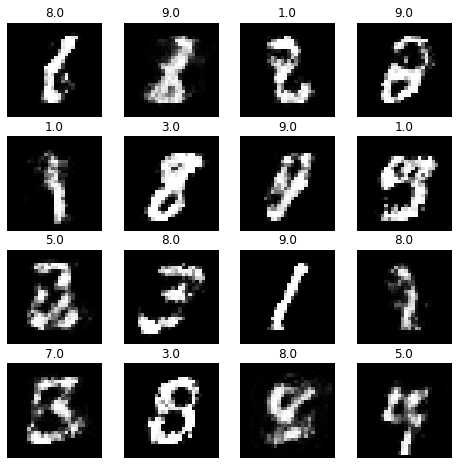

Epoch: 46 | Generator Loss: 1.26517 | Discirminator Loss: 0.29046


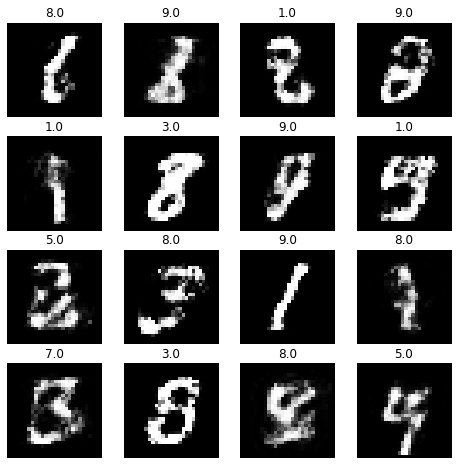

Epoch: 47 | Generator Loss: 1.28014 | Discirminator Loss: 0.28753


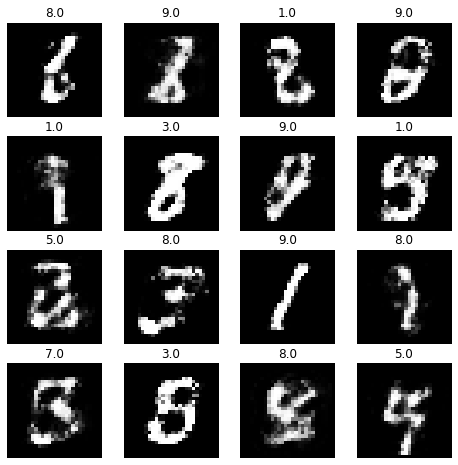

Epoch: 48 | Generator Loss: 1.28569 | Discirminator Loss: 0.28864


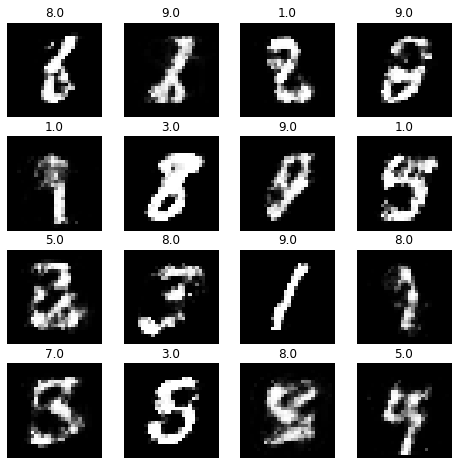

Epoch: 49 | Generator Loss: 1.28537 | Discirminator Loss: 0.29149


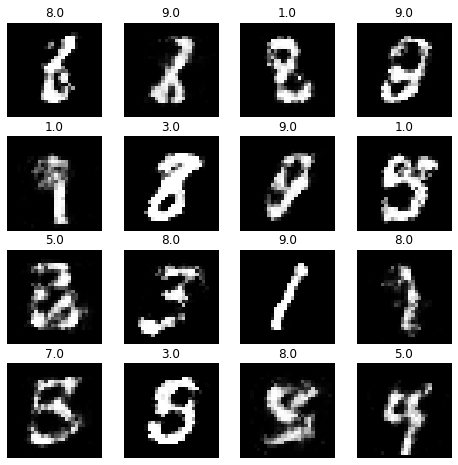

Epoch: 50 | Generator Loss: 1.29463 | Discirminator Loss: 0.28996


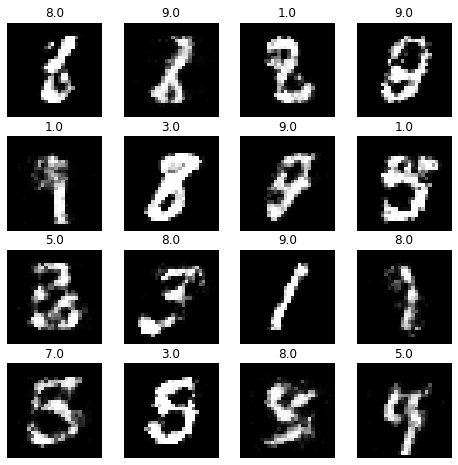

Epoch: 51 | Generator Loss: 1.29057 | Discirminator Loss: 0.29032


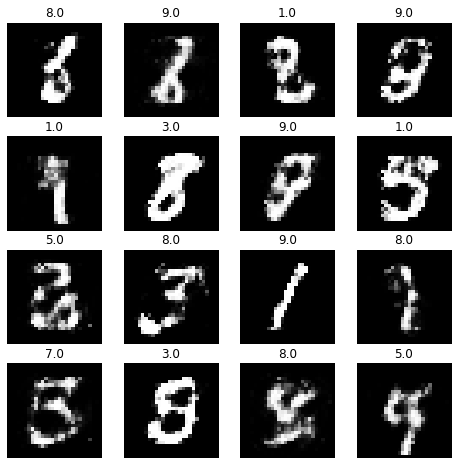

Epoch: 52 | Generator Loss: 1.29324 | Discirminator Loss: 0.29260


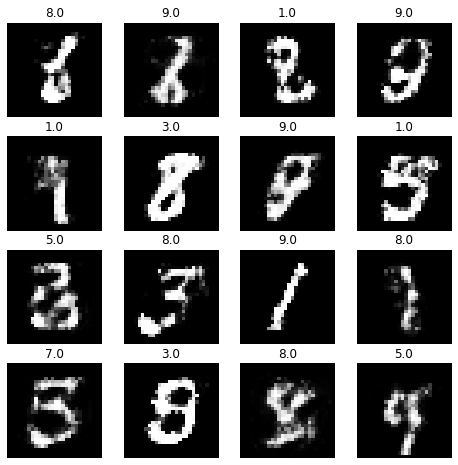

Epoch: 53 | Generator Loss: 1.29234 | Discirminator Loss: 0.28948


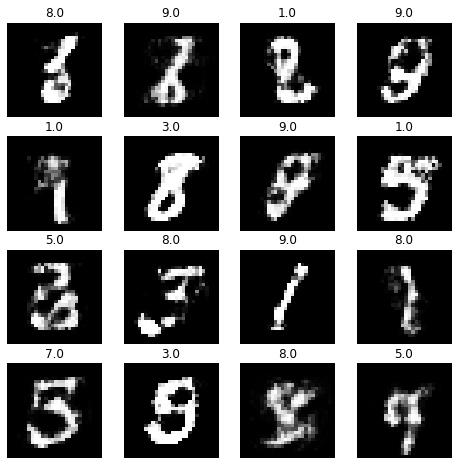

Epoch: 54 | Generator Loss: 1.30019 | Discirminator Loss: 0.29310


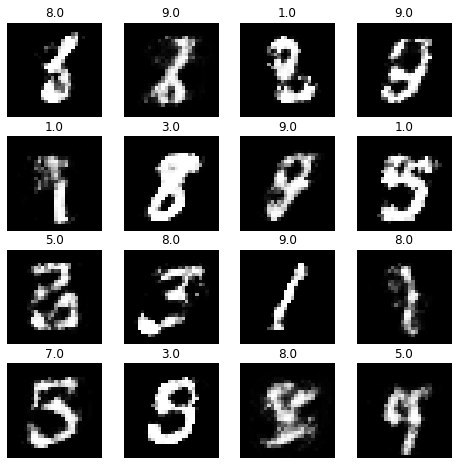

Epoch: 55 | Generator Loss: 1.29071 | Discirminator Loss: 0.29377


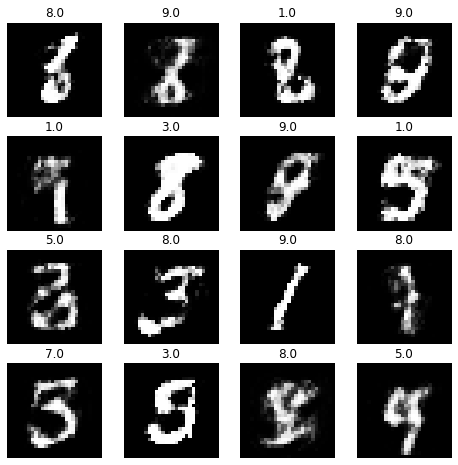

Epoch: 56 | Generator Loss: 1.30099 | Discirminator Loss: 0.29088


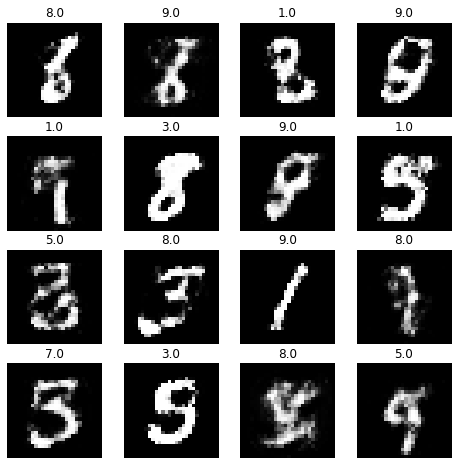

Epoch: 57 | Generator Loss: 1.29940 | Discirminator Loss: 0.29028


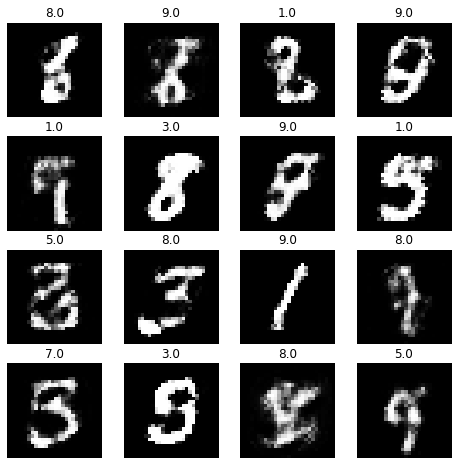

Epoch: 58 | Generator Loss: 1.30067 | Discirminator Loss: 0.29275


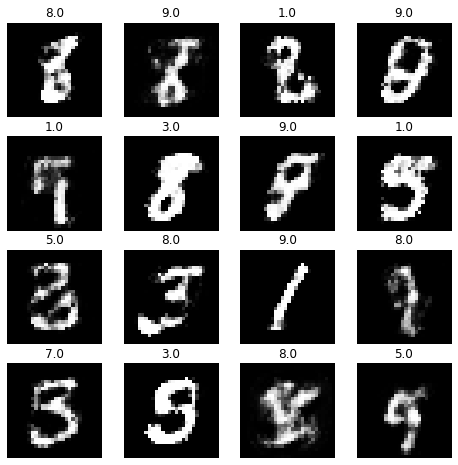

Epoch: 59 | Generator Loss: 1.29499 | Discirminator Loss: 0.29555


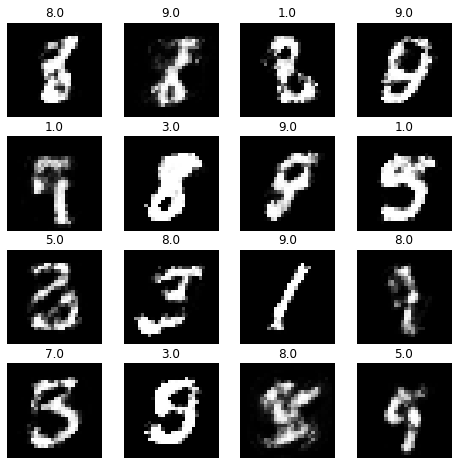

Epoch: 60 | Generator Loss: 1.29141 | Discirminator Loss: 0.29404


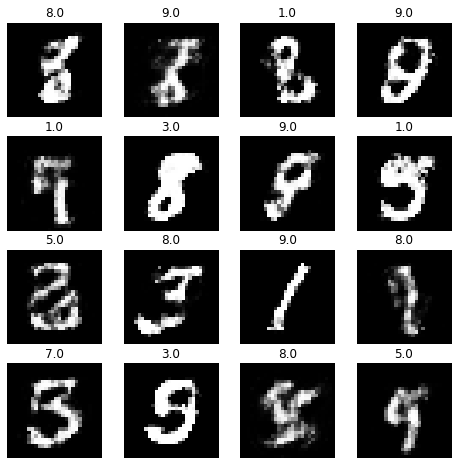

Epoch: 61 | Generator Loss: 1.30306 | Discirminator Loss: 0.29236


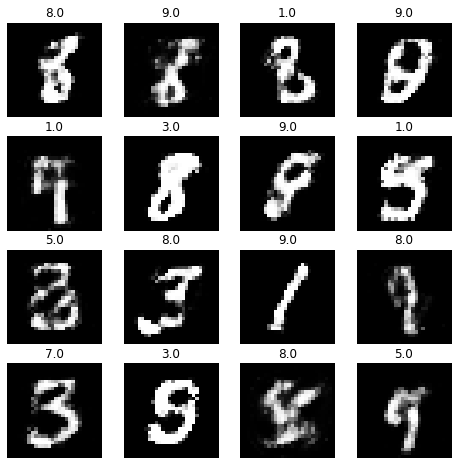

Epoch: 62 | Generator Loss: 1.29810 | Discirminator Loss: 0.29246


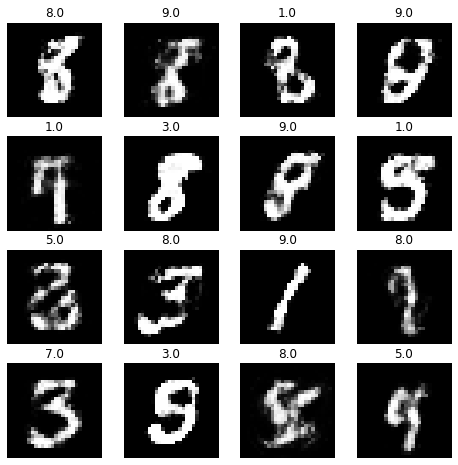

Epoch: 63 | Generator Loss: 1.30472 | Discirminator Loss: 0.29414


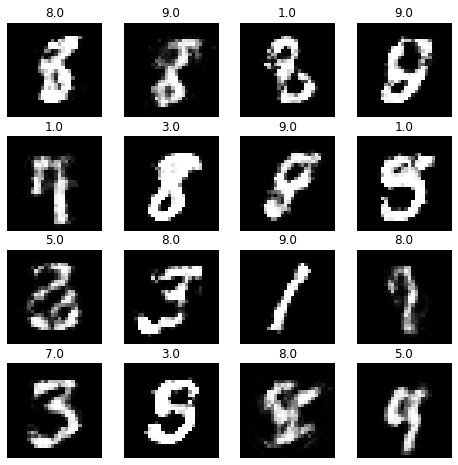

Epoch: 64 | Generator Loss: 1.29894 | Discirminator Loss: 0.29627


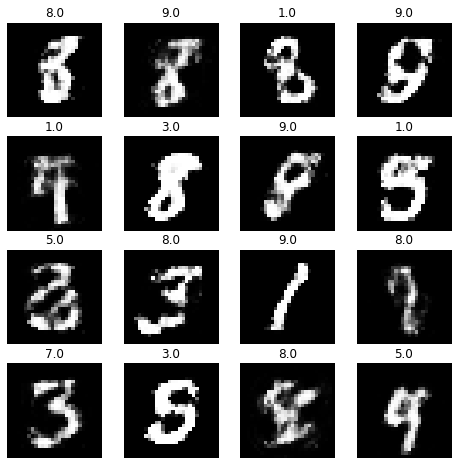

Epoch: 65 | Generator Loss: 1.30473 | Discirminator Loss: 0.29453


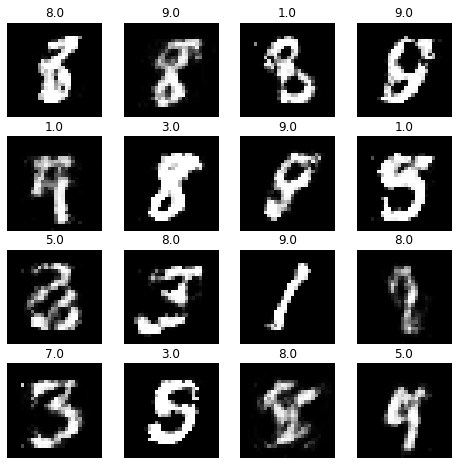

Epoch: 66 | Generator Loss: 1.29808 | Discirminator Loss: 0.29684


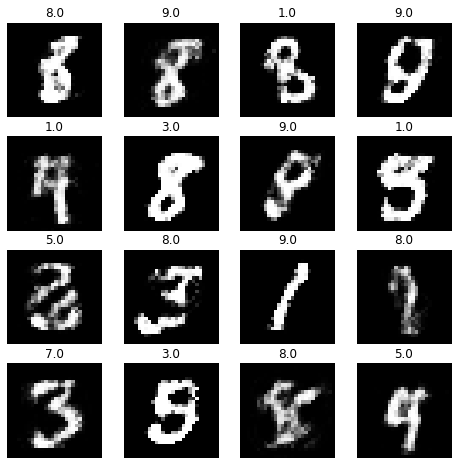

Epoch: 67 | Generator Loss: 1.29472 | Discirminator Loss: 0.29885


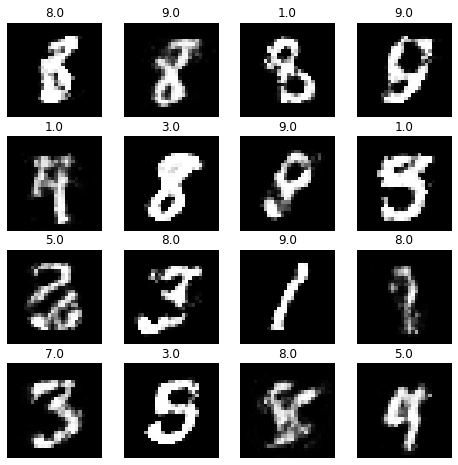

Epoch: 68 | Generator Loss: 1.29839 | Discirminator Loss: 0.29998


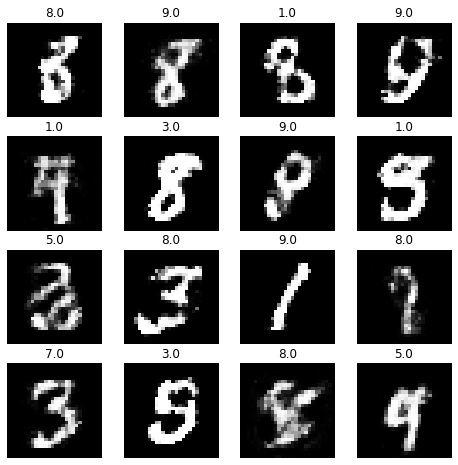

Epoch: 69 | Generator Loss: 1.29155 | Discirminator Loss: 0.30066


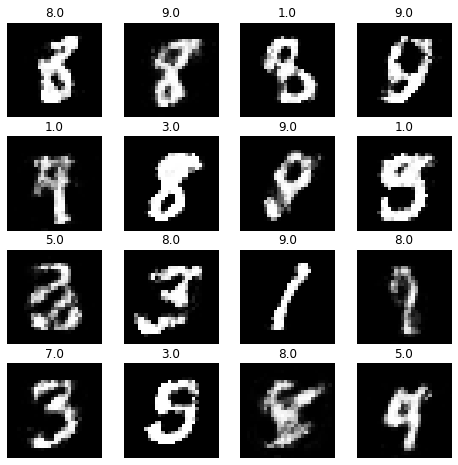

Epoch: 70 | Generator Loss: 1.28945 | Discirminator Loss: 0.30027


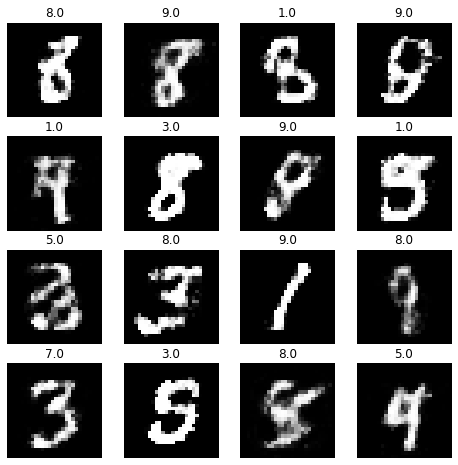

Epoch: 71 | Generator Loss: 1.28069 | Discirminator Loss: 0.30649


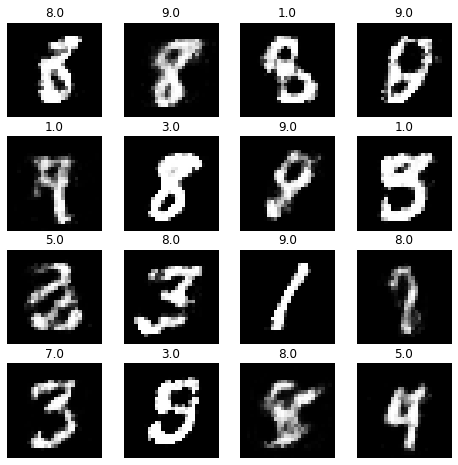

Epoch: 72 | Generator Loss: 1.27946 | Discirminator Loss: 0.30444


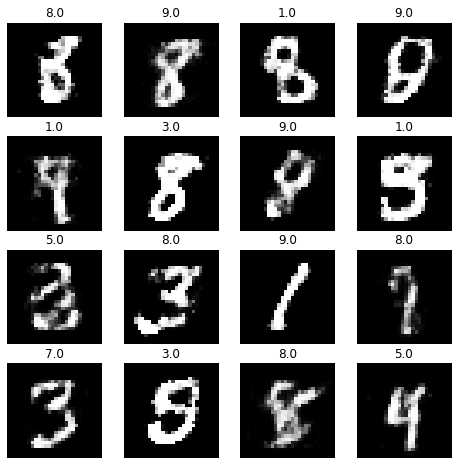

Epoch: 73 | Generator Loss: 1.27268 | Discirminator Loss: 0.30786


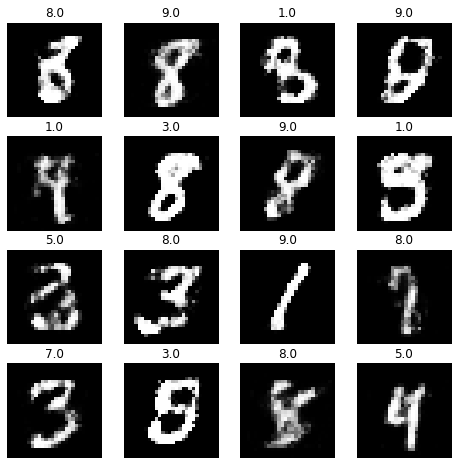

Epoch: 74 | Generator Loss: 1.26973 | Discirminator Loss: 0.31037


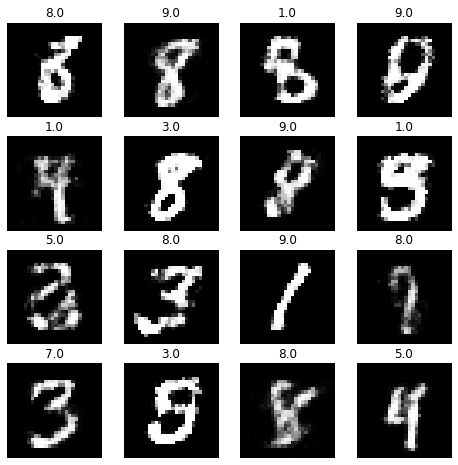

Epoch: 75 | Generator Loss: 1.25976 | Discirminator Loss: 0.30877


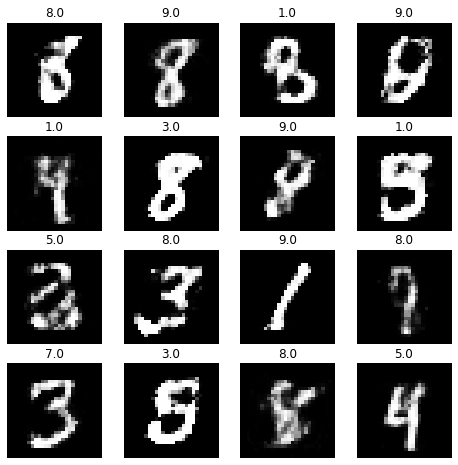

Epoch: 76 | Generator Loss: 1.26414 | Discirminator Loss: 0.30955


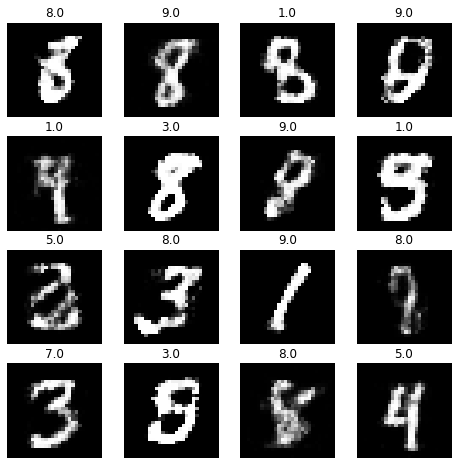

Epoch: 77 | Generator Loss: 1.26016 | Discirminator Loss: 0.30787


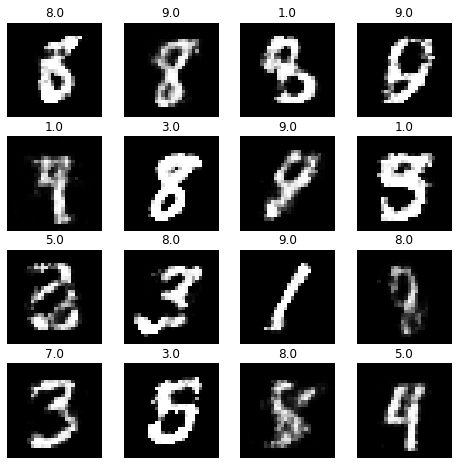

Epoch: 78 | Generator Loss: 1.25574 | Discirminator Loss: 0.30894


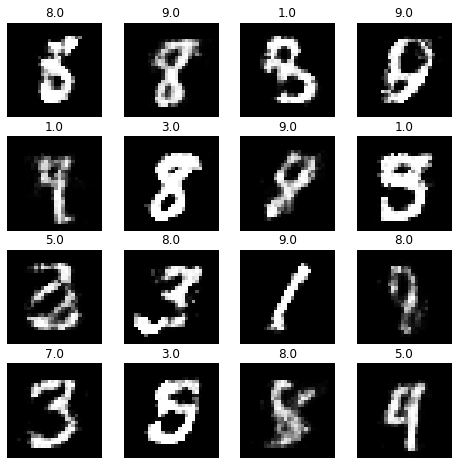

Epoch: 79 | Generator Loss: 1.26610 | Discirminator Loss: 0.30782


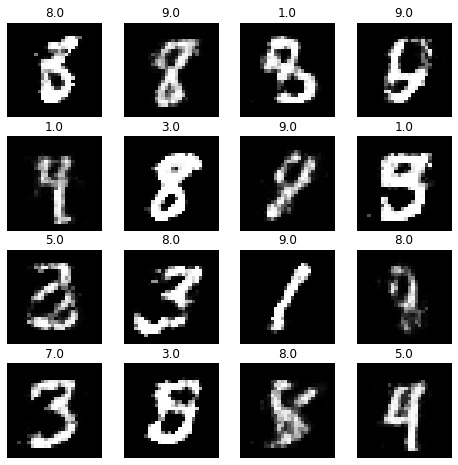

Epoch: 80 | Generator Loss: 1.26248 | Discirminator Loss: 0.30783


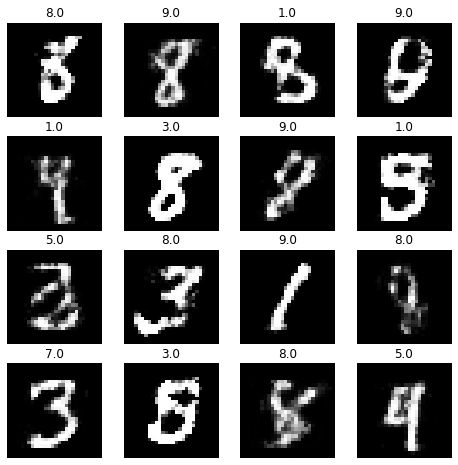

Epoch: 81 | Generator Loss: 1.25673 | Discirminator Loss: 0.30689


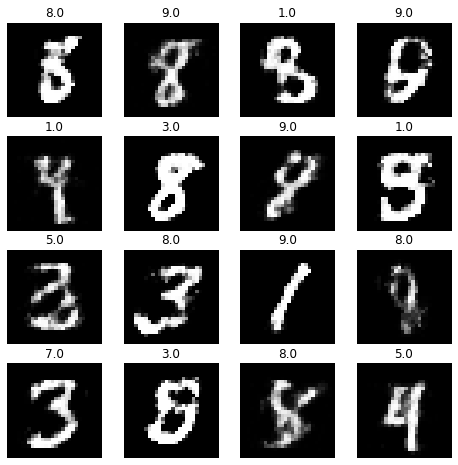

Epoch: 82 | Generator Loss: 1.26478 | Discirminator Loss: 0.30773


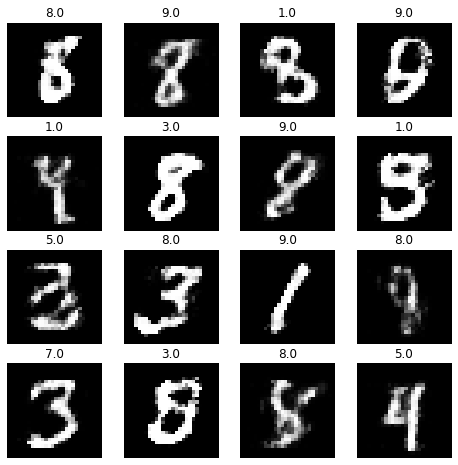

Epoch: 83 | Generator Loss: 1.25940 | Discirminator Loss: 0.30595


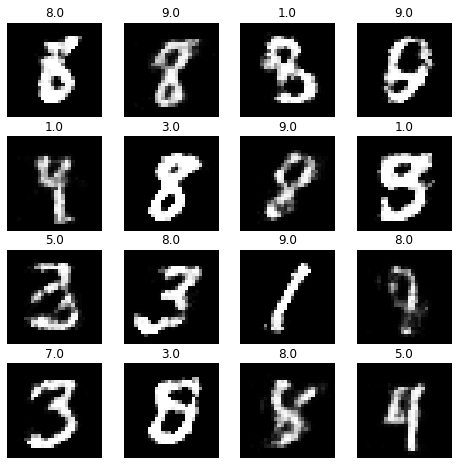

Epoch: 84 | Generator Loss: 1.26008 | Discirminator Loss: 0.30598


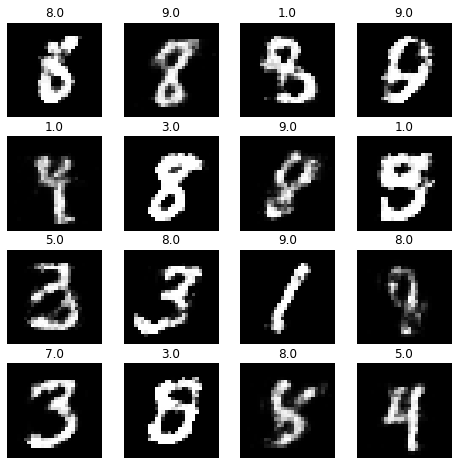

Epoch: 85 | Generator Loss: 1.26497 | Discirminator Loss: 0.30738


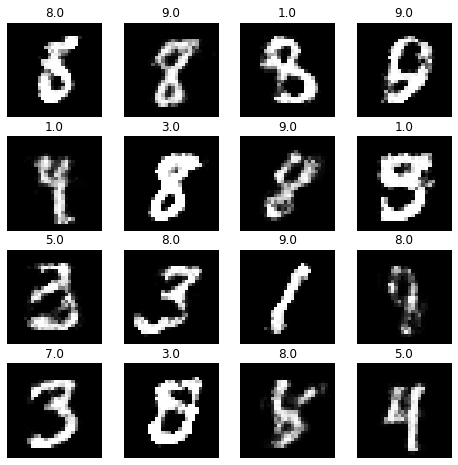

Epoch: 86 | Generator Loss: 1.27114 | Discirminator Loss: 0.30727


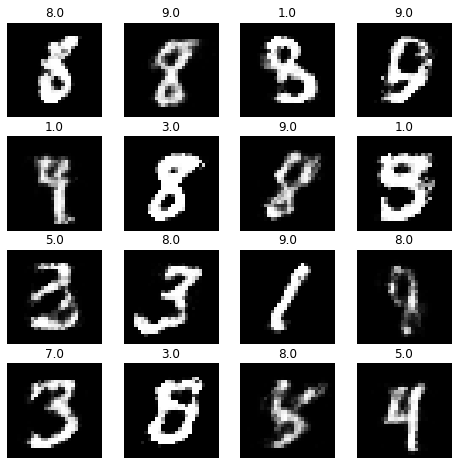

Epoch: 87 | Generator Loss: 1.26436 | Discirminator Loss: 0.30676


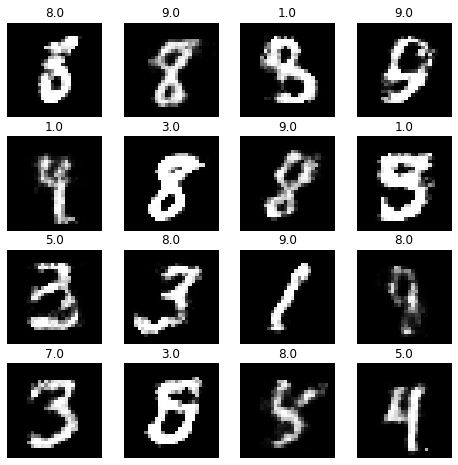

Epoch: 88 | Generator Loss: 1.26615 | Discirminator Loss: 0.30442


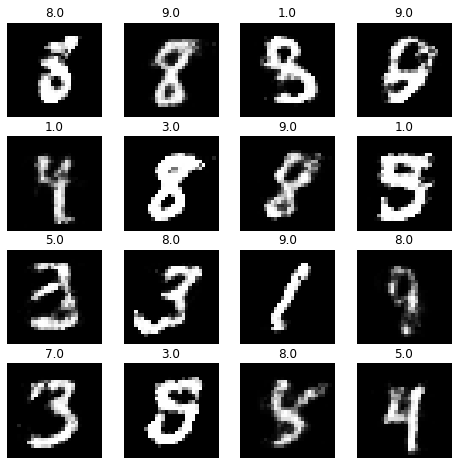

Epoch: 89 | Generator Loss: 1.26929 | Discirminator Loss: 0.30261


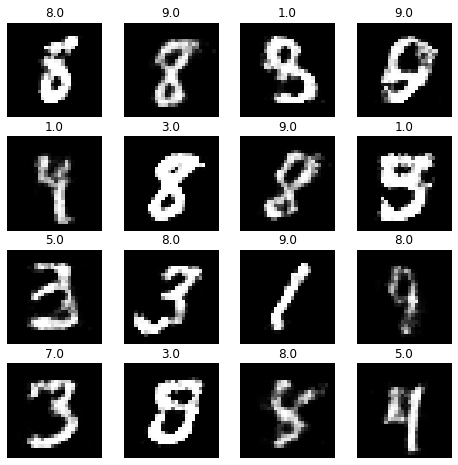

Epoch: 90 | Generator Loss: 1.27362 | Discirminator Loss: 0.30389


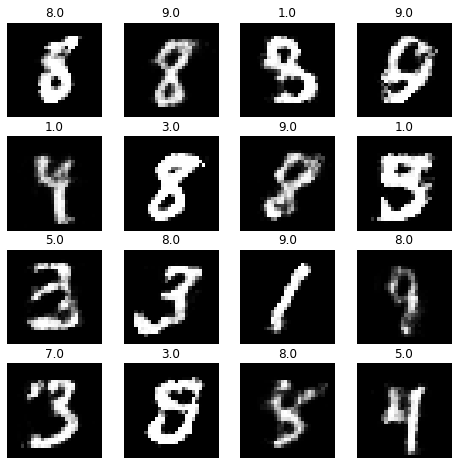

Epoch: 91 | Generator Loss: 1.29072 | Discirminator Loss: 0.30027


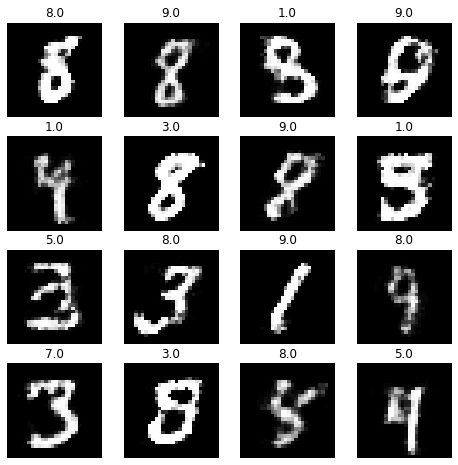

Epoch: 92 | Generator Loss: 1.27922 | Discirminator Loss: 0.30231


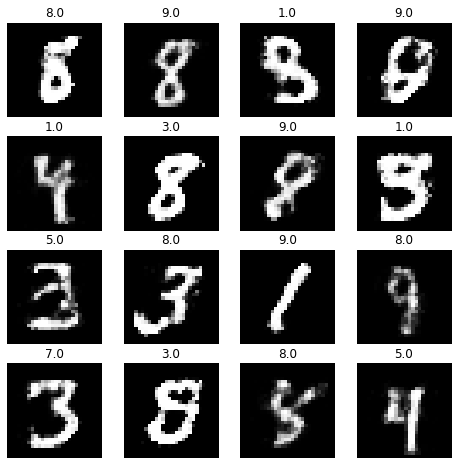

Epoch: 93 | Generator Loss: 1.27601 | Discirminator Loss: 0.30266


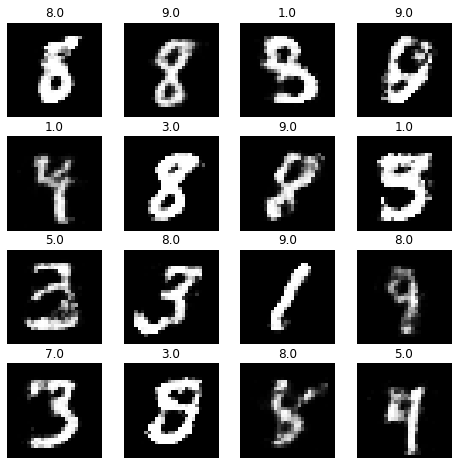

Epoch: 94 | Generator Loss: 1.27649 | Discirminator Loss: 0.30044


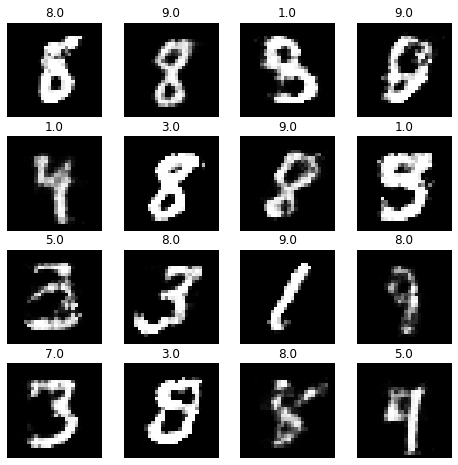

Epoch: 95 | Generator Loss: 1.28721 | Discirminator Loss: 0.29972


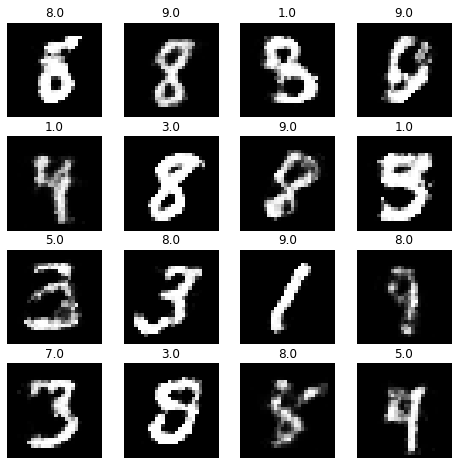

Epoch: 96 | Generator Loss: 1.28168 | Discirminator Loss: 0.30227


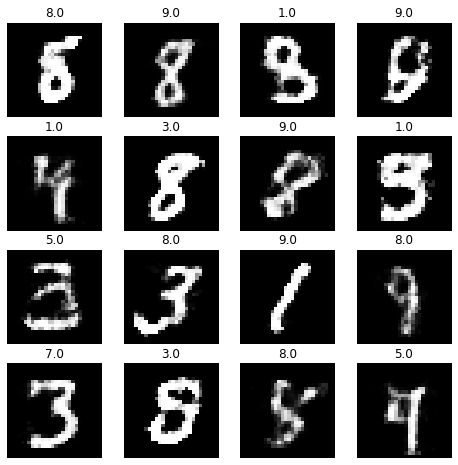

Epoch: 97 | Generator Loss: 1.28234 | Discirminator Loss: 0.30194


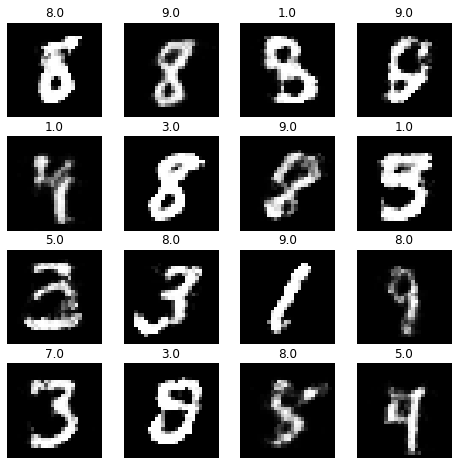

Epoch: 98 | Generator Loss: 1.28434 | Discirminator Loss: 0.29693


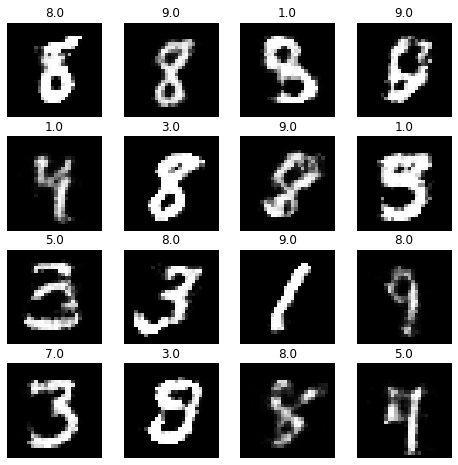

Epoch: 99 | Generator Loss: 1.29088 | Discirminator Loss: 0.30469


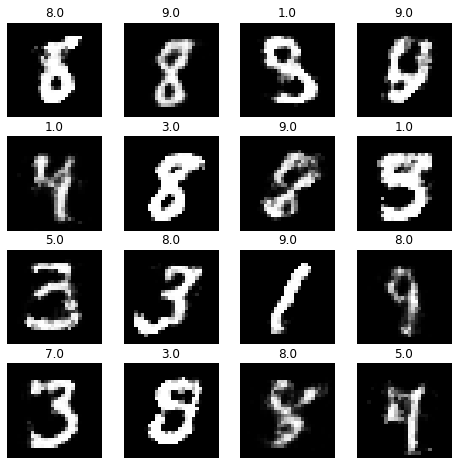

In [14]:
epochs = 100 # a gan usually takes a lot of epochs to work properly
num_batches = 60000//batch_size
learning_rate = 0.001

Glosses = []
Dlosses = []

t = 0.0

sample_z = nd.random.normal(0, 1, (16, 100)).as_in_context(ctx)
sample_y = nd.random.randint(0, 10, (16)).as_in_context(ctx).one_hot(10)

for epoch in range(epochs):
    gcum_loss = 0.0
    dcum_loss = 0.0
    for features, labels in training_data:
        t += 1
        features = features.as_in_context(ctx)
        true_labels = labels.as_in_context(ctx).one_hot(10)

        z = nd.random.normal(0, 1, (features.shape[0], 100)).as_in_context(ctx)
        false_labels = nd.random.randint(0, 10, (features.shape[0])).as_in_context(ctx).one_hot(10)

        with autograd.record():
            generated = generator(z, false_labels)
            false, false_aux = discriminator(generated)
            Gloss = gloss(false, false_aux, false_labels)
        Gloss.backward()
        adam(t, gparams, vs = gvs, sqrs = gsqrs, lr = learning_rate)
        
        with autograd.record():
            true, true_aux = discriminator(features)
            false, false_aux = discriminator(generated)
            Dloss = dloss(true, true_aux, true_labels, false, false_aux, false_labels)
        Dloss.backward()
        adam(t, dparams, vs = dvs, sqrs = dsqrs, lr = learning_rate)
        
        gcum_loss += Gloss
        dcum_loss += Dloss
    
    Gloss = gcum_loss.asscalar()/num_batches
    Dloss = dcum_loss.asscalar()/num_batches
    
    Glosses.append(Gloss)
    Dlosses.append(Dloss)
    
    print(f'Epoch: {epoch} | Generator Loss: {Gloss:.5f} | Discirminator Loss: {Dloss:.5f}')
    
    generated = generator(sample_z, sample_y)
    plt.figure(figsize = (8, 8))
    for i, (image) in enumerate(generated[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.reshape((28, 28)).asnumpy(), cmap = 'gray')
        plt.title(sample_y[i].argmax(0).asscalar())
        plt.axis('off')
    plt.show()

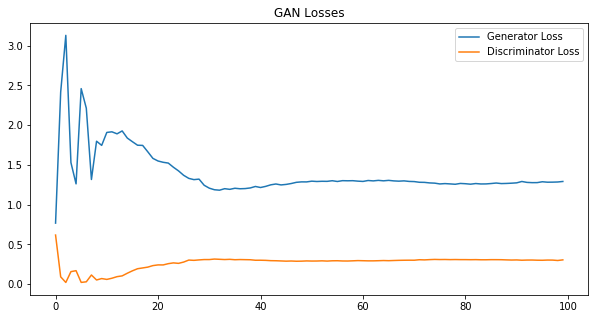

In [15]:
plt.figure(figsize = (10, 5))
plt.plot(Glosses, label = 'Generator Loss')
plt.plot(Dlosses, label = 'Discriminator Loss')
plt.legend()
plt.title('GAN Losses')
plt.show()

## Now lets generate some more data base on our desired output category
First column contain all zeros, second column all ones and so on...

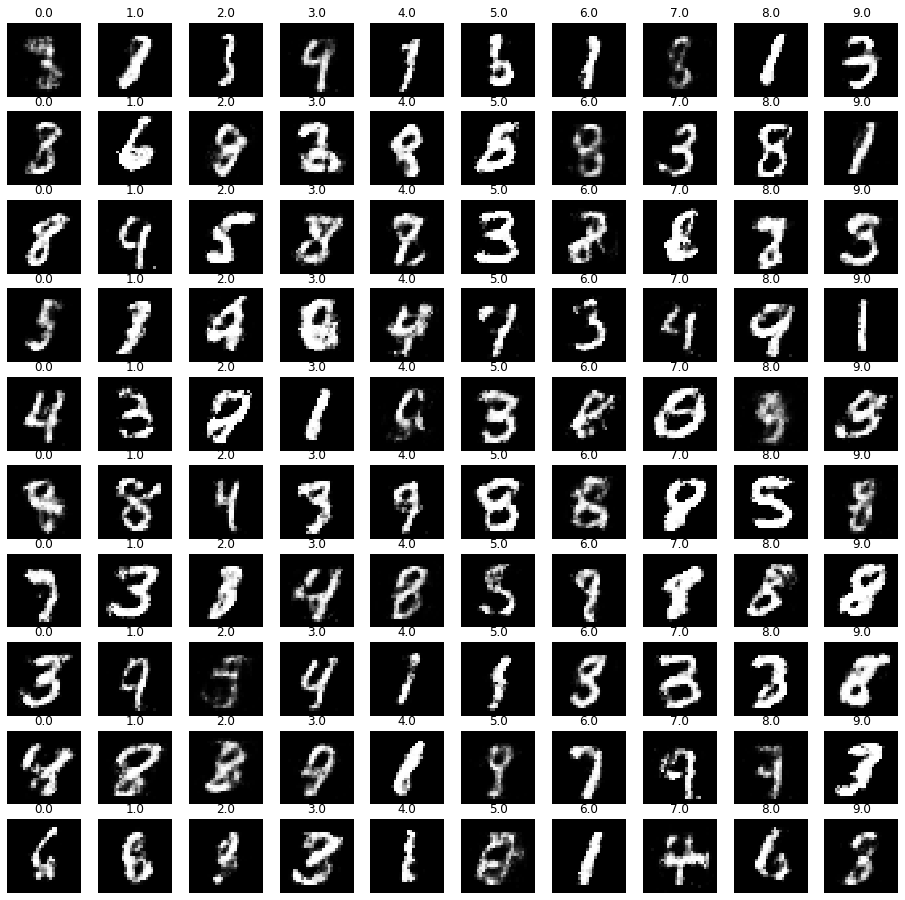

In [16]:
labels = nd.arange(0, 10, 1).tile(10).one_hot(10).as_in_context(ctx)
noise = nd.random.normal(loc = 0, scale = 1, shape = (100, 100)).as_in_context(ctx)

generated = generator(noise, labels)

plt.figure(figsize = (16, 16))
for i, (image, label) in enumerate(zip(generated, labels)):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
    plt.title(label.argmax(0).asscalar())
    plt.axis('off')
plt.show()

As you can see that our generator is not properly conditioned as in conditional gan, because we are combining the discriminator with just true and false data, unlike conditional gan where we combine (concatenate) features and labels as one input.

But with more complex model architectures, AC-GAN can easily generate better and high quality images as compared go C-GAN.